#####필요 함수들

In [1]:
import numpy as np

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

def softmax(a):
    exp_a = np.exp(a)       #브로드캐스트
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

#5. 오차역전파법

- computational graph와 chain rule을 이용하여 numerical diff보다 빠르게 수행가능
- $G_{downstreaming} = G_{local} * G_{upstreaming}$
- 오차역전파로 계산하고, 수치미분으로 검산

##단순한 계층 구현하기

곱셈 계층 : gradient를 swap해서 곱한다

In [2]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    # 순전파
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        return out
    
    # 역전파
    def backward(self, dout):   #upstream_grad를 param으로 준다
        dx = dout * self.y
        dy = dout * self.x
        return dx, dy

덧셈 계층 : gradient를 그대로 흘린다

In [3]:
class AddLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    # 순전파
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x + y
        return out
    
    # 역전파
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

##Activation 구현하기

ReLU

In [4]:
class Relu:
    def __init__(self):
        self.mask = None
    
    def forward(self, x):
        self.mask = (x <= 0)        # 0 이하인 곳을 확인
        out = x.copy()
        out[self.mask] = 0      # 0으로 바꿈
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0     # 역전파할 전달안 된 곳은 0
        dx = dout
        return dx

Sigmoid

- $y' = y(1-y)$

In [5]:
class Sigmoid:
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out     # y' = y * (1-y)
        return dx

##Affine / Softmax 계층 구현

Affine 계층

- 행렬 곱으로 생각해야 함
- **weight와 grad의 shape은 항상 같다**

In [6]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.original_x_shape = None        # batch_size도 고려하기 위함
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        
        # 편향은 각 데이터의 역전파 값을 다 모아야함
        self.db = np.sum(dout, axis=0)      
        
        # 입력 데이터 모양 변경(텐서 대응)
        dx = dx.reshape(*self.original_x_shape)
        return dx

Softmax-with-Loss 계층

In [7]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)     # softmax 활용
        self.loss = cross_entropy_error(self.y, self.t)     # cross_entropy_error
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

##오차역전파법 구현하기

**network 학습의 큰 그림**

1. 미니배치
2. 기울기 산출
    - Backpropaganda 사용!
3. parameter update
4. 반복

In [8]:
# layer 순서 보존을 위해 사용
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    # 오차역전파법 구현
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()        # 순서 바꿔서 순차적 역전파
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

#6. 학습 관련 기술들

##6.1 매개변수 갱신

손실함수 값을 최소화하는 곳을 찾아가는 **최적화** 과정

- 여러 방법이 있는데 문제에 맞는 optimizer를 선택해야 함
- Adam이 국룰

####SGD

- $W = W - \eta\dfrac{\partial{L}}{\partial{W}}$
- weight space가 scale이 다를 때 비효율적으로 업데이트되는 단점이 있다

In [9]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    # grad와 현재 param값을 넘겨 줌
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

####모멘텀

- $v = \alpha v - \eta\dfrac{\partial{L}}{\partial{W}}$ : 모멘텀 계산
- $W = W + v$
- $\alpha v$항은 마찰에 해당함

-> 모멘텀(속도)을 이용해서 효율적인 업데이트를 한다

In [10]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None       # 모멘텀을 담는 변수
        
    def update(self, params, grads):
        # 모멘텀 담기
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]    # 모멘텀 update
            params[key] += self.v[key]      # param update

####AdaGrad

- grad의 크기에 맞춰서 학습률을 조정한다
- $h = h - \dfrac{\partial{L}}{\partial{W}}.\dfrac{\partial{L}}{\partial{W}}$   : elementwise muliply
- $W = W - \eta\dfrac{1}{\sqrt{h}}\dfrac{\partial{L}}{\partial{W}}$

-> grad가 크면 학습률이 낮아지고, 작으면 학습률이 커짐

In [11]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None       # lr 스케일 조정
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]      # grad 스케일 확인
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)     #lr 조정

####Adam

- Momentum + AdaGrad

In [12]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

##6.2 가중치의 초깃값

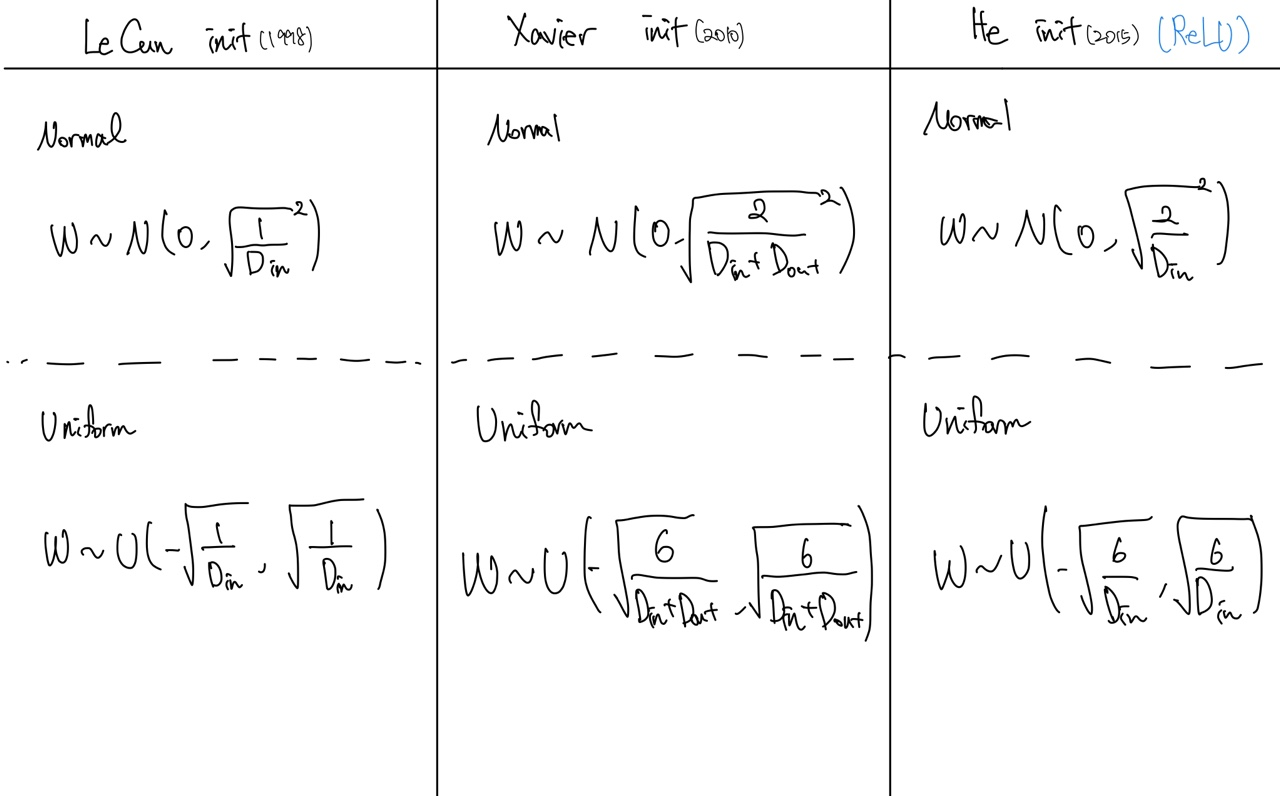

##6.3 배치 정규화

- 입력의 분포를 일정하게 해줌
- 미분가능해서 역전파 가능
- nonlinearity를 얼마나 줄지 학습할 수 있음

##6.4 바른 학습을 위해

- 오버피팅이 제일 안좋은 것
- Loss에 Weight의 L2 노름을 더해서 가중치 감소를 유도
- 드롭아웃으로 특정 노드에 의존하는 것을 방지

####Loss에 Weight의 L2노름을 더함

In [13]:
def loss(self, x, t):
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            
            #weight의 L2 놈 더하기
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

####드롭아웃

In [14]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:   #훈련때만 드롭아웃 적용
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        
        else:       #아닐 때는 비율 빼주기
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

##6.5 하이퍼파라미터 튜닝

####검증 데이터

- 튜닝할 땐 검증 데이터로 튜닝
- 랜덤 서치 / 그리드 서치

#7. CNN

##기본 컨셉

**키워드**

- convolutioning
- feature map
- padding / stride
- pooling


##구현하기

im2col을 이용해서 필터링하기 좋게 전개한다.

In [15]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape

    # output_size 미리 계산
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


####합성곱 계층 구현

In [16]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        # 행렬곱 할 수 있도록 input과 weight를 펼친다
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b       # 합성곱 계산
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)    #모양 맞추기

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    # 역전파 구현..
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

####풀링 계층 구현

In [17]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)       #out에서 최댓값 찾기 : max pooling
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

##CNN 구현하기

In [18]:
class SimpleConvNet:
    """구조
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """

    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        y = self.predict(x)

        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()    #오차 역전파법
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

##CNN 시각화 하기

- 층이 깊어질수록 detail한 특징을 학습한다
- 대표적인 CNN은 LeNet, AlexNet이 있다

#8. 딥러닝

##더 깊게!!

- 층을 깊게 하고, 작은 filter를 사용하면 receptive field 대비 params 갯수가 효율적이다
- 깊을수록 더 디테일한 특성까지 학습하므로 더 좋다
- 학습해야할 문제를 계층적으로 나눌 수 있다
- 정보를 계층적으로 전달할 수도 있다
- GPU의 발전이 큰 도움을 주었다

##대표적인 CNN

####VGG

3 * 3의 작은 필터의 conv층을 연속으로 사용

-> 효율적인 params

####GoogLeNet

- 세로 방향 깊이뿐 아니라 가로 방향도 깊다
- 인셉션 구조 사용
- 1 * 1 convolution으로 channel과 params 수를 조절한다

####ResNet

- 스킵 연결을 사용해서 변화량만을 학습하게 한다
- identity adding으로 인해서 역전파될 때 gradient highway가 생긴다 -> gradient 전파에 좋다

##딥러닝의 활용

####Object Detection

- R-CNN
- Fast R-CNN
- Faster R-CNN

####Segmentation

FCN을 이용해서 spatial하도록 줄이고, 다시 deconvolution을 사용해서 복원

####Image Captioning

- CNN + RNN
- CNN으로 그림의 feature를 학습, RNN으로 feature로부터 자연어 처리
- **멀티모달 처리** : 여러 종류의 정보를 조합, 처리하는 작업